# Exercise 3


## Part I - creating a useful data format

Like in Exercise1, we will use `FWLite` to read the miniAOD files. In order to make things easier we will store the information we are interested in into a `pandas.DataFrame`, think of it as an in-memory form of `ROOT::TTree`, on steroids :).

__Why using a `pandas.DataFrame`?__
   - It's _fast_ (as much as C++)
   - It's simple
   - it avoids having to re-load the data every time like on FWLite
   - conversion to modern data science/machine learning tools is immediate

__but works only in memory, not good for very large datasets__

In [1]:
import ROOT
import rootpy #hands down, a better version of PyROOT
import rootpy.plotting as plt
import pprint
from DataFormats.FWLite import Events, Handle
import pandas as pd
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)

Welcome to JupyROOT 6.12/07


We now load the input file(s) and loop over them storing the relevant information. `data` will store the information we want to keep.

In [2]:
data = []
events = Events(
    'root://cmseos.fnal.gov//store/user/hats/2019/Tagging/TTToSemiLeptonic_RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15/D7F68ED3-7D8A-0A4E-A53E-D5557F11760C.root'
)
handle = Handle('vector<pat::Jet>')
for event in events:
    event.getByLabel('slimmedJets', handle)
    jets = handle.product()
    for jet in jets:
        if jet.pt() < 20 or abs(jet.eta()) > 2.4: continue #basic selection
        #A more verbose, but more consistent version with dictionaries exists
        data.append([
            jet.pt(),
            jet.eta(),
            jet.bDiscriminator('pfCombinedInclusiveSecondaryVertexV2BJetTags'),
            jet.bDiscriminator('pfCombinedMVAV2BJetTags'), #not use in this exercise
            jet.bDiscriminator('pfDeepCSVJetTags:probb') + jet.bDiscriminator('pfDeepCSVJetTags:probbb'),
            jet.bDiscriminator('pfDeepFlavourJetTags:probb') + jet.bDiscriminator('pfDeepFlavourJetTags:probbb') \
            + jet.bDiscriminator('pfDeepFlavourJetTags:problepb'),
            abs(jet.hadronFlavour()), #5 - b-jet, 4 - c-jet, 0 - light
        ])

Let's make a DataFrame out of `data`

In [3]:
data = pd.DataFrame(data, columns=['pt', 'eta', 'CSVv2', 'cMVAv2', 'deepCSV', 'deepFlavour', 'flavour'])

You can check the content of the first row of `data` with

In [4]:
data.head()

,pt,eta,CSVv2,cMVAv2,deepCSV,deepFlavour,flavour
0,139.667496,0.464149,0.993057,0.999898,0.993107,0.999950,5
1,119.036491,0.508618,0.076074,-0.983291,0.009236,0.002705,0
2,61.337147,-0.743259,0.942440,0.849547,0.886184,0.999117,5
3,41.983410,-1.037987,-10.000000,-0.976409,-2.000000,0.009116,0
4,20.903563,0.808915,0.196064,-0.968939,0.061913,0.079160,0


## Part II - efficiency plots

The efficiency is defined as:

$ N_{b}^{passing}/N_{b}^{total} $

Similarly the fake-rate is defined as:

$ N_{non-b}^{passing}/N_{non-b}^{total} $

We will compute the efficiency and fake rates as a function of the jet $p_{T}$, furthermore, we will divide the fake rate into the charm (`flavour == 4`) and light (`flavour == 0`). 

The threshold for the different discriminator and working points can be found [here](https://twiki.cern.ch/twiki/bin/viewauth/CMS/BtagRecommendation80XReReco). As you can see, they were meant for last year's data-taking, while the simulated samples we are using are for this year. 

Let's define the threshold somewhere we can easily access:

In [5]:
thresholds = {
    'CSVv2' : {
        'L' : 0.5803,
        'M' : 0.8838,
        'T' : 0.9693,
    }, 
    'deepCSV' : {
        'L' : 0.1522,
        'M' : 0.4941,
        'T' : 0.8001
    },
    'deepFlavour' : {
        'L' : 0.0521,
        'M' : 0.3033,
        'T' : 0.7489
    }
}

And make a set of histograms with a similar structure. At the same time we also define some basic cosmetics.

In [6]:
binning = [20, 30, 40, 60, 80, 100, 150, 300, 600]
efficiencies = {}

#define histograms, and a bit of cosmetics 
for flavour, style in zip([5, 4, 0], [20, 22, 23]):
    efficiencies[flavour] = {}
    for algo, color in zip(['CSVv2', 'deepCSV','deepFlavour'], ['red', 'green', 'blue']):
        efficiencies[flavour][algo] = {}
        for wp in ['L', 'M', 'T']:
            efficiencies[flavour][algo][wp] = plt.Hist(binning)
            efficiencies[flavour][algo][wp].markercolor = color
            efficiencies[flavour][algo][wp].markerstyle = style
            efficiencies[flavour][algo][wp].title = '%s %s' % (algo, wp)

For each algorithm, working point and $p_T$ bin we compute the efficiency and the fake rates.

Few tips for filling the code block below:
  - To make a selection in the `DataFrame` do `frame[frame.COLUMN ==/>/< value]`, you can assign the output to a new variable
  - combine cuts with the bitwise and `(frame.COLUMN ==/>/< ...) & ...`
  - access the bin edges with `histo_bin.x.low/high`

In [7]:
#
# FILL THE CODE WHERE NEEDED
#
for flavour in efficiencies:
    jets = data[data.flavour==flavour]#FIXME select only one type of jet flavour
    for algo in efficiencies[flavour]:
        for wp in efficiencies[flavour][algo]:
            histo = efficiencies[flavour][algo][wp]
            thr = thresholds[algo][wp]
            for hbin in histo: #Loop over histogram bins
                if hbin.overflow: continue #skip under/overflow bins
                #select jets within a pt bin: you can combine the cuts with the bit-wise
                pt_cut = (jets.pt>=hbin.x.low) & (jets.pt<hbin.x.high) #FIXME
                selJets_pt_cut = jets[pt_cut] #FIXME
                #now calculate efficiency
                #numerator: selJets with b-tag discriminator > thr
                nNu = (selJets_pt_cut[algo] > thr).sum()#FIXME
                #denominator: all selJets
                nDe = selJets_pt_cut.shape[0] #FIXME
                hbin.value = float(nNu)/nDe
                

We can now make plots

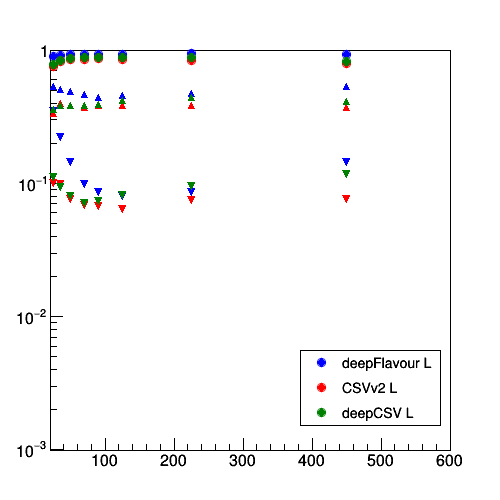

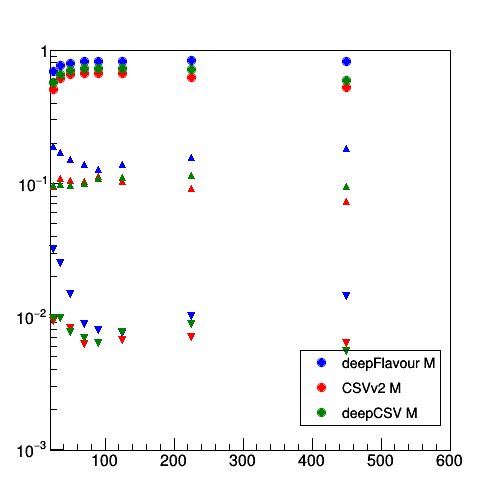

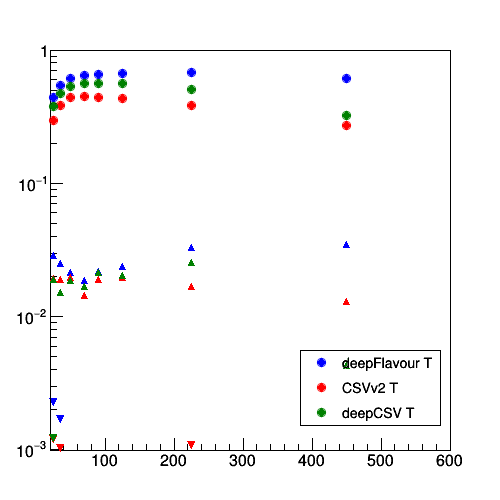

In [8]:
keep = [] #we just need this to avoid ROOT to mess-up with python
for wp in 'LMT':
    canvas = plt.Canvas(500, 500)
    canvas.SetLogy()
    legend = plt.Legend(3, entrysep=0.00, rightmargin=0.02, entryheight=0.05, textsize=0.03, topmargin=0.6)
    first = True
    for flavour in efficiencies:
        for algo in efficiencies[flavour]:
            efficiencies[flavour][algo][wp].yaxis.range_user = (0.001,1)
            efficiencies[flavour][algo][wp].Draw('p' if first else 'p same')            
            first = False
            if flavour == 5: #do not overcrowd the legend
                legend.AddEntry(efficiencies[flavour][algo][wp])
    legend.Draw()
    canvas.Draw()
    keep.extend([legend, canvas])

## Part III - ROC Curves

From the previous plots can you tell which is the most performing algorithm?

To show both effect in a single plots it is customary to plot the results in a [ROC Curve](https://it.wikipedia.org/wiki/Receiver_operating_characteristic). To do so, we will use [scikit-learn](http://scikit-learn.org/), a (if not __the__) machine learning library for python. For plotting we will use [matplotlib](https://matplotlib.org/) a python-centric plotting library, most of the scientific and data analysis python libraries work seamlessly with matplotlib, much less so with ROOT, and it even has an [xkcd style](https://matplotlib.org/examples/showcase/xkcd.html).

In [15]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as pyplt
from sklearn.metrics import roc_curve

In [16]:
data['isB'] = (data.flavour == 5)
data.head()

,pt,eta,CSVv2,cMVAv2,deepCSV,deepFlavour,flavour,isB
0,139.667496,0.464149,0.993057,0.999898,0.993107,0.999950,5,True
1,119.036491,0.508618,0.076074,-0.983291,0.009236,0.002705,0,False
2,61.337147,-0.743259,0.942440,0.849547,0.886184,0.999117,5,True
3,41.983410,-1.037987,-10.000000,-0.976409,-2.000000,0.009116,0,False
4,20.903563,0.808915,0.196064,-0.968939,0.061913,0.079160,0,False


In [17]:
data[np.isnan(data.deepCSV)] = 0

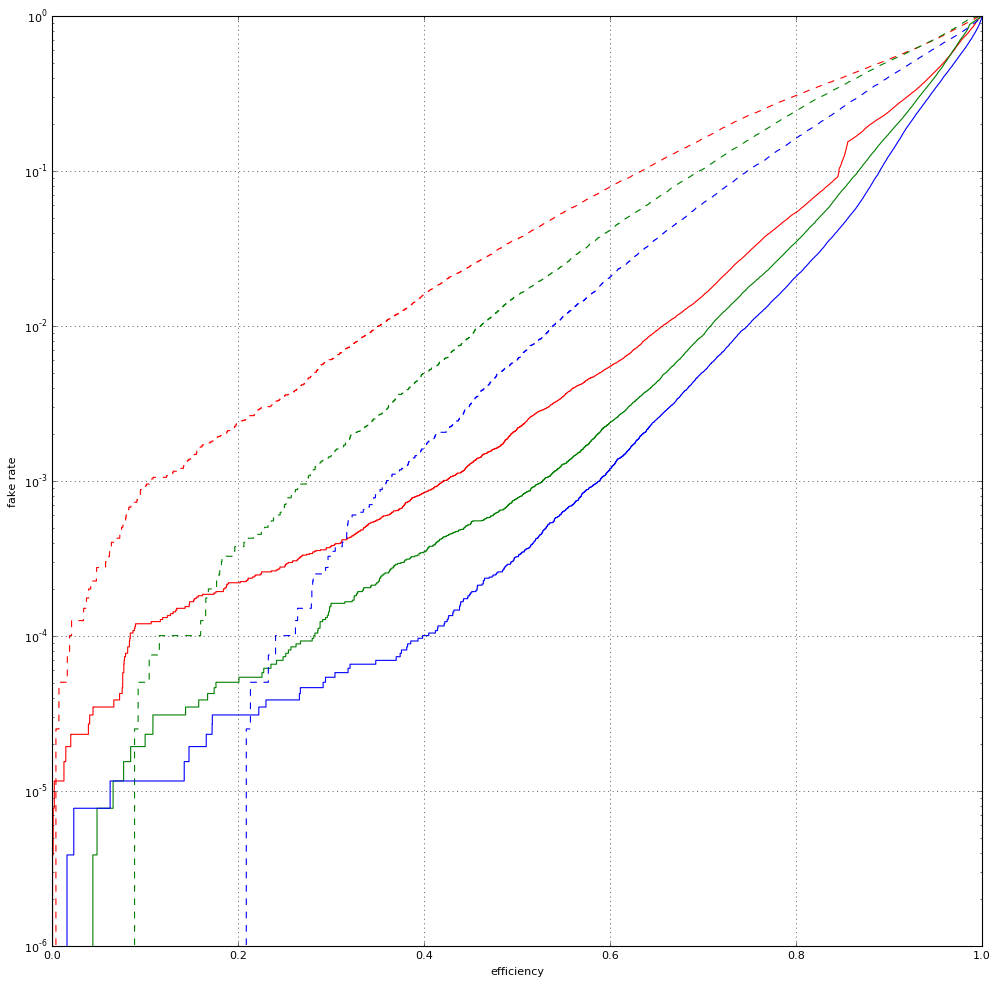

In [18]:
fig = pyplt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')
for algo, color in zip(['CSVv2', 'deepCSV', 'deepFlavour'], 'rgb'):    
    for bkg, style in zip([4, 0], ['-', '--']): #- solid line -- dash line
        mask = (data.flavour != bkg)
        jets = data[mask]
        fakes_positive_rate, true_positive_rate, _ = roc_curve(jets.isB, jets[algo])
        pyplt.plot(true_positive_rate, fakes_positive_rate, '%s%s' % (color, style))

pyplt.xlabel('efficiency')
pyplt.ylabel('fake rate')
pyplt.grid(True)
pyplt.yscale('log', nonposy='clip')
pyplt.show()